# Example of how to use the Dataset class

#### Import the Dataset and Lightcurve modules from MALT

In [3]:
from malt import Dataset
from malt import Lightcurve
import os

/home/kimeel/Documents/SKA-fellowship/MALT/malt_env/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


#### The Dataset object is a collection of Lightcurve objects. All the parameters of the Dataset object can be set manually when initialising the object or preferably by using the config file, the default config file is shown below

In [1]:
!cat MALT.config

#***********************************************************#
#                   MALT Config File                        #
#***********************************************************#

##---------------------------------------------------------##
#               Parameters for interpolation                #
[INTERPOLATOR]
#Options: True or False
interpolate = True
#Must be function from interpolator.py
interp_func = get_gp
#Options: 'rand', 'start', or any float
ini_t = 'rand'
#Time in days
obs_time = 0.3333333333333333
#Integer
sample_size = 100


##---------------------------------------------------------##
#             Parameters for machine learning               #
[ML]
#Must be function from feature_extraction.py
feat_ex_method = get_wavelet_feature
#Must be function from machine_learning.py
ml_method = RFclassifier
#Must be a dictionary
hyperparams = {"n_estimators": np.arange(70,90),"criterion": ["gini", "entropy"]}
#Integer
n_jobs= -1
#Options: True or False
pca = True
#Inte

#### All functionality of the dataset object is controlled by this config file. The user can choose whether they would like to intepolate the data or not and what intepolation function to use. If the user decides to use a different interpolation function then it should be added to the interpolator.py file. The user can also choose to use different feature extraction functions and machine learning algorithms which should be added to feature_extraction.py and machine_learning.py respectively. If a different machine learning algorithm is chosen it should either be from the sklearn package or be writting in a sklearn wrapper.

#### We can now initialise the MALT dataset object with parameters from config file.

In [6]:
dataset = Dataset(configFile='MALT.config')

#### Get a list of all data files

In [7]:
root = 'example_data/'
allfiles = []
for path, subdirs, files in os.walk(root):
    for filename in files:
        f = os.path.join(path, filename)
        allfiles.append(f)

#### Import files into dataset object 

In [8]:
dataset.populate(allfiles)

#### Now that we have populated the Dataset with Lightcurves we can check what objects we have in the dataset. If the user has chosen to use GP augmentation we can also show the number of augmented lightcurves.

In [9]:
dataset.types()

AGN         :    17
Flare-Star  :     3
GRB         :     4
Kilonova    :     1
Magnetar    :     1
Nova        :     8
SN          :    13
TDE         :     2
--------------------
Total       :    49


In [10]:
dataset.types(show_aug_num=True)

AGN         :  1700
Flare-Star  :   300
GRB         :   400
Kilonova    :   100
Magnetar    :   100
Nova        :   800
SN          :  1300
TDE         :   200
--------------------
Total       :  4900


#### We can train the ML algorithm on the objects in the dataset in one easy step. This will check all the parameters in the config file and perform the interpolation and feature extraction methods that the user has defined before training. 

In [8]:
dataset.train()


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   15.1s finished


GridSearchCV took 15.83 seconds for 40 candidate parameter settings.


#### The user could also choose to manually Interpolate all Lightcurves in dataset and perform feature extraction.

In [ ]:
dataset.interpolate()
dataset.extract_features()

#### We can check the performance of the trained algorithm by running a diagnostic test. This will train a classifier on a subset of the whole dataset a number of times (defined by the user). 

In [9]:
d = dataset.run_diagnostic()

GridSearchCV took 6.66 seconds for 40 candidate parameter settings.
GridSearchCV took 8.20 seconds for 40 candidate parameter settings.
GridSearchCV took 10.26 seconds for 40 candidate parameter settings.
GridSearchCV took 9.99 seconds for 40 candidate parameter settings.
GridSearchCV took 9.74 seconds for 40 candidate parameter settings.



#### We can then plot the results of the test. This will output 3 plots showing confusion matrixies for the run with the min, max and average overall accuracies.

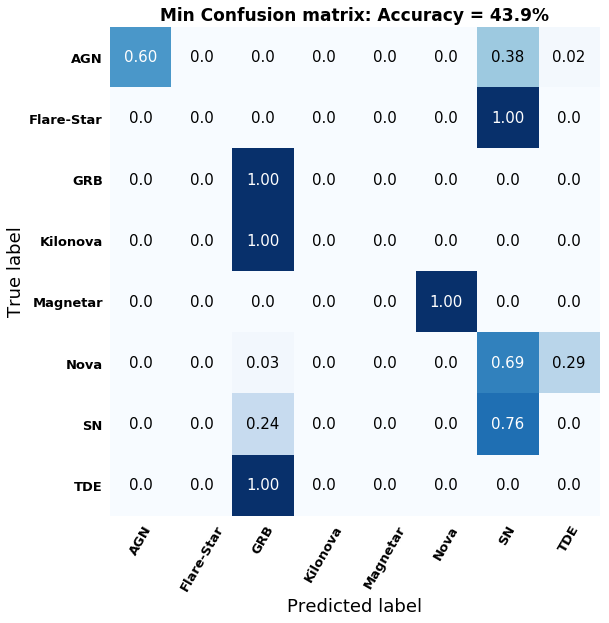

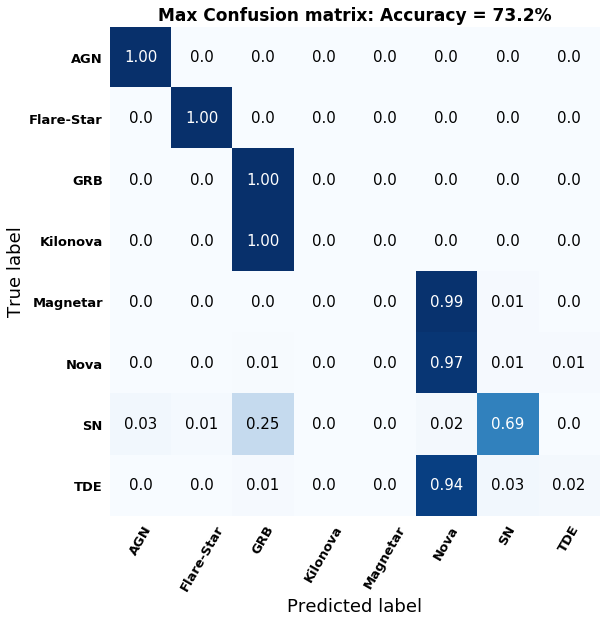

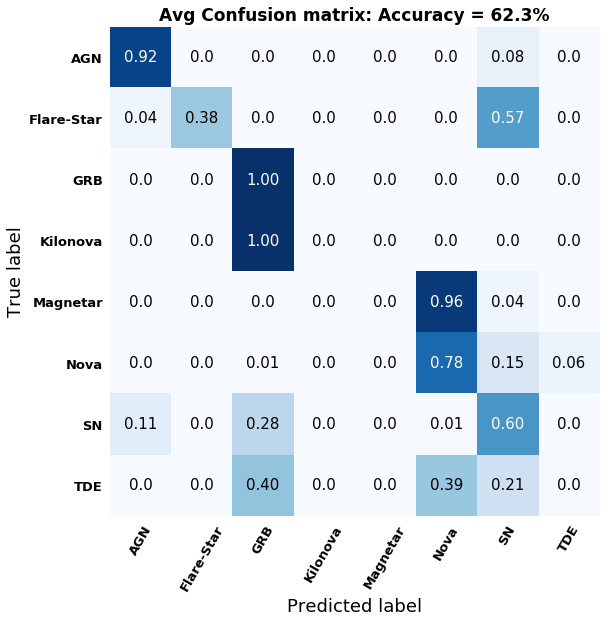

In [10]:
d.plot_results()

#### Now that we have a trained classifier, we can use it to classify new objects. First we will load a test file into a Lightcurve object. Because we do not know the type of this object we can see that it's type attribute is None.

In [11]:
new_lightcurve = Lightcurve('3C120_test')
new_lightcurve.type

'None'

#### We can now use the trained classifier to predict class of this object.

In [12]:
prob, label = dataset.predict(new_lightcurve)
print(prob,label)

0.9518072289156626 AGN


#### The full probability breakdown can also be outputed.

In [13]:
prob,label = dataset.predict(new_lightcurve,show_prob=True)

AGN         : 95.18%
Flare-Star  : 1.20%
GRB         : 0.00%
Kilonova    : 0.00%
Magnetar    : 0.00%
Nova        : 0.01%
SN          : 2.43%
TDE         : 1.17%


#### Once the type of the new object is confirmed we can add it back into the Dataset. Once that is done the classifier will be automatically retrained using this new object. 

In [14]:
new_agn = Lightcurve('3C120_test',obj_type='AGN')
print('Type: ',new_agn.type)

'AGN'

In [15]:
dataset.add(new_agn)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   11.0s finished


GridSearchCV took 11.51 seconds for 40 candidate parameter settings.


#### We can see that there is now one more object in the dataset.

In [16]:
dataset.types()

AGN         :    18
Flare-Star  :     3
GRB         :     4
Kilonova    :     1
Magnetar    :     1
Nova        :     8
SN          :    13
TDE         :     2
--------------------
Total       :    50


#### The dataset can be saved (using pickle) and loaded from a saved file.

In [17]:
dataset.save('Malt_demo')

Saved Dataset to Malt_demo.save


In [18]:
reloaded_dataset = Dataset.load_from_save('Malt_demo.save')


Loaded Dataset to Malt_demo.save.save


In [19]:
prob,label = reloaded_dataset.predict(new_lightcurve,show_prob=True)

AGN         : 96.30%
Flare-Star  : 0.00%
GRB         : 0.00%
Kilonova    : 0.00%
Magnetar    : 0.00%
Nova        : 3.70%
SN          : 0.00%
TDE         : 0.00%


## Everything is logged in a file called dataset.log

In [20]:
cat lightcurve.log

2019-08-07 18:01:21 - lightcurve_logger - INFO - Initialising Dataset with parameters from config file: MALT.config
2019-08-07 18:01:35 - lightcurve_logger - INFO - Func get_gp() used saved gp: ./saved/gps/Sco2012.txt.gpsave
2019-08-07 18:01:35 - lightcurve_logger - INFO - Func get_gp() used saved gp: ./saved/gps/ADLeo.gpsave
2019-08-07 18:01:35 - lightcurve_logger - INFO - Func get_gp() used saved gp: ./saved/gps/UVCet.gpsave
2019-08-07 18:01:35 - lightcurve_logger - INFO - Func get_gp() used saved gp: ./saved/gps/SN2004dk.txt.gpsave
2019-08-07 18:01:35 - lightcurve_logger - INFO - Func get_gp() used saved gp: ./saved/gps/GRB970508.txt.gpsave
2019-08-07 18:01:35 - lightcurve_logger - INFO - Func get_gp() used saved gp: ./saved/gps/B0605-085.gpsave
2019-08-07 18:01:35 - lightcurve_logger - INFO - Func get_gp() used saved gp: ./saved/gps/3C345.gpsave
2019-08-07 18:01:35 - lightcurve_logger - INFO - Func get_gp() used saved gp: ./saved/gps/GRB060418.txt.gpsave
2019-08-07 18:01:35 - light